# 1. Предобработка


Выберите набор данных: <font color='yellow'>
[Anime dataset](https://www.kaggle.com/thunderz/anime-dataset?select=user_data.csv) - данные о просмотре аниме пользователями с сайта myAnimeList</font>

Обработайте данные в нём:

1. Обработайте недостающие данные в датасете - удалить/заменить/etc, обоснуйте своё решение

<font color='yellow'>Удалены: столбец где все значения одинаковы(статус), строки, где нет даты премьеры аниме(aired_from)

Заменены: столбец duration из текстовых значений времени(35 минут, 1 час 45 минут) заменены на числа(длительность в минутах без системы единиц),
по aired_from вставленны пропущенные данные в столбец premierd(сезон-год), aired_to aired_from переведены в формат год-месяц-день (удалены время в часах минутах и тд) </font>

2. Постройте как минимум по 1 графику каждого типа из представленных на лекции. Для каждого построенного графика объясните почему отображённые данные лучше всего представимы именно этим типом графика
3. Сохраните датасет

<font color='yellow'>Сохранено в data - new_anime_data</font>

4. Создайте новую колонку, отображающую характеристику набора данных. Новая колонка должна обладать смысловой нагрузкой. 

<font color='yellow'>Была создана колонка длина аниме (что есть количество эпизодов на их длину)</font>


In [3]:
#TASK1
from numpy import NaN, int64
import math 
import re
import pandas as pd

anime_df = pd.read_csv('data/raw/anime_data.csv')

#Анализируем данные с помощью следующих инструментов
#pd.unique(anime_df.type) - список уникальных значений столбца
#anime_df.info() - object, int, float какие значения по типам в столбцах
#anime_df.describe() - основные статистики
#anime_df.source.value_counts() - значение + количество их в столбце
#anime_df.head()
#попробуем заменить данные типа object на что-то получше, убираем Nan

#Удаляем
#частичное удаление aired_from чтобы построить от не Nan значений aired_to и premiered 
anime_df.dropna(subset=['aired_from'], inplace=True) #delete rows which aiered_from is NaN

#имеется только один Currently Airing в статусе, остальные Finished, поэтому эта колонка не будет иметь вес при анализе 
anime_df = anime_df.drop(['status'], axis=1) #delete all colomn

#Заменяем
#convert aired-s to yyyy-mm-dd
anime_df.aired_from = pd.to_datetime(anime_df.aired_from).dt.date
anime_df.aired_to = pd.to_datetime(anime_df.aired_to).dt.date

In [4]:
#Некоторые вспомогательные функции
#1. convert duration from "y hr x min per ep" to "z" min
def get_duration_in_min(series: pd.Series) -> pd.Series:
    s = []
    for t in series.split():
        try:
            s.append(int(t))
        except ValueError:
            pass
    if (len(s) == 0):
        return NaN
    if (len(s) == 1):
        return s[0]
    if (len(s) == 2):
        return s[0]*60 + s[1]
anime_df.duration = anime_df.duration.apply(get_duration_in_min)

#2. convert from quarter of season to season name
def month_to_season(n: pd.Series) -> pd.Series:
    if (n == 1):
        return "Winter"
    elif (n == 2):
        return "Spring"
    elif (n == 3):
        return "Summer"
    elif (n == 4):
        return "Fall"

#3. convert year to string format
def my_strftime(year: pd.Series) -> pd.Series:
    return year.strftime('%Y')

In [5]:
#NaN заменяем на default values
default = {"aired_to": anime_df.aired_from,  # begin and end in one day
            "duration": anime_df.duration.mean(),
            "synopsis": "",
            "title_english": anime_df.title,
            "title": anime_df.title_english,
            "premiered": (pd.to_datetime(anime_df.aired_from).dt.month % 12 // 3 + 1).apply(month_to_season) +
            # месяц преобразуем в номер четверти и по нему
            ' ' + pd.to_datetime(anime_df.aired_from).apply(my_strftime),
            #вычисляем время года, после добавляем год, преобразованный в строку
            }
anime_df.fillna(default, inplace=True)

#дополнительно
#удаляем остатки где неизвестен тайтл после обработки
anime_df.dropna(subset=['title'], inplace=True)
anime_df.rename(columns={'rating': 'age_rating'}, inplace=True)
anime_df.head(1)


,mal_id,aired_from,aired_to,duration,episodes,genres,popularity,premiered,rank,age_rating,score,scored_by,source,studios,synopsis,title,title_english,type
0,1,1998-04-03,1999-04-24,24.0,26,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,"[{'mal_id': 14, 'name': 'Sunrise'}]","In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV


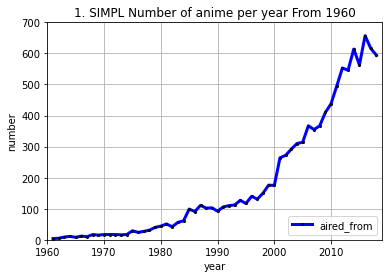

In [6]:
#TASK2
import matplotlib.pyplot as plt

# 1. ПРОСТОЙ ГРАФИК с дополнительными параметрами
# Количество аниме вышедших в определенный год (берем период от околонулевого значения до года создания csvшника -1)
# воспользуемся всеми улучшениями визульного восприятия графика, чтобы прочувствовать прелести построения графиков на личном опыте
year_val = pd.to_datetime(anime_df[(pd.to_datetime(anime_df.aired_from).dt.year > 1960) & (pd.to_datetime(
    anime_df.aired_from).dt.year < 2019)].aired_from).dt.year.value_counts().sort_index()
year_val.plot(color='blue', marker='o',
              markeredgecolor='black', markersize=2,
              linewidth=3, grid=True)
plt.xlabel("year")
plt.ylabel("number")
plt.title('1. SIMPL Number of anime per year From 1960')
plt.legend(loc='lower right')
plt.xlim((1960, 2019))
plt.ylim((0, 700))
plt.show()
#из этого графика можно увидеть как возрастало количество аниме в течении 60 лет

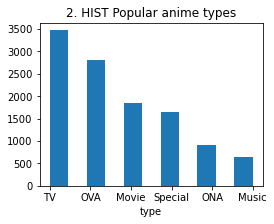

In [7]:
# 2. ГИСТОГРАММА
# Популярность различных типов аниме
plt.figure(figsize=(4, 3))
plt.hist(anime_df.type, bins=11)
plt.title("2. HIST Popular anime types")
plt.xlabel("type")
plt.show()

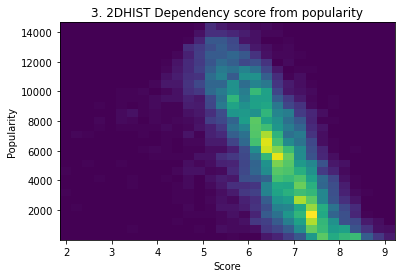

In [8]:
# 3. 2D ГИСТОГРАММА
#  Зависимость рейтинга от популярности
plt.hist2d(anime_df.score, anime_df.popularity, bins=30)
plt.title("3. 2DHIST Dependency score from popularity")
plt.ylabel("Popularity")
plt.xlabel("Score")
plt.show()
#из этого графика хорошо видно что более популярне аниме чаще всего имеют высокие оценки

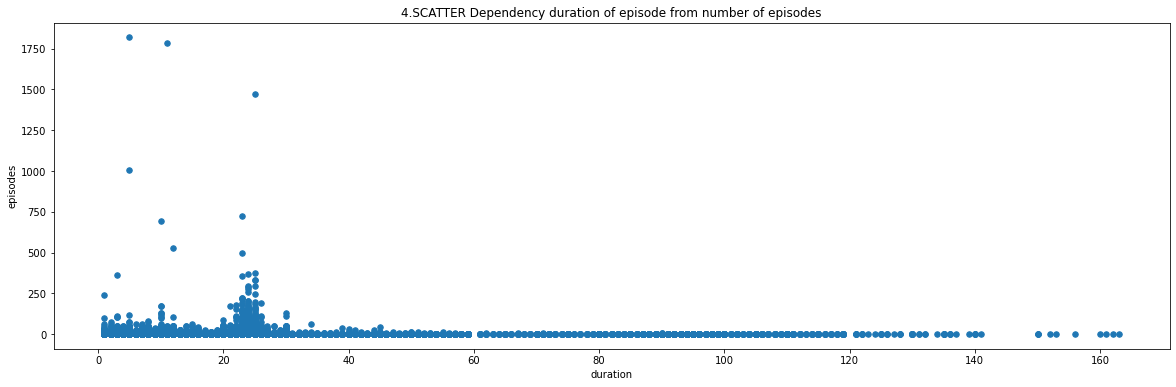

In [9]:
# 4. РАССЕЯНИЯ
# Зависимость длины эпизода от количества эпизодов
plt.figure(figsize=(20, 6))
plt.scatter(anime_df.duration,  # если хочется сократить объем данных
            # [(anime_df.episodes < 2000) & (anime_df.duration < 200)]
            anime_df.episodes,
            s=30,  # Меняет размер точки
            )
plt.title("4.SCATTER Dependency duration of episode from number of episodes")
plt.ylabel("episodes")
plt.xlabel("duration")
plt.show()

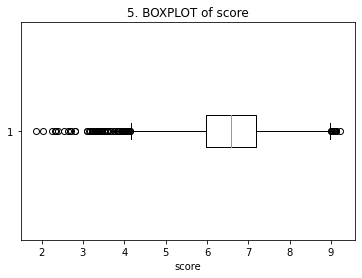

In [10]:
# 5. BOXPLOT
plt.boxplot(anime_df.score, vert=False)
plt.title("5. BOXPLOT of score")
plt.xlabel("score")
plt.show()

<Figure size 432x288 with 0 Axes>

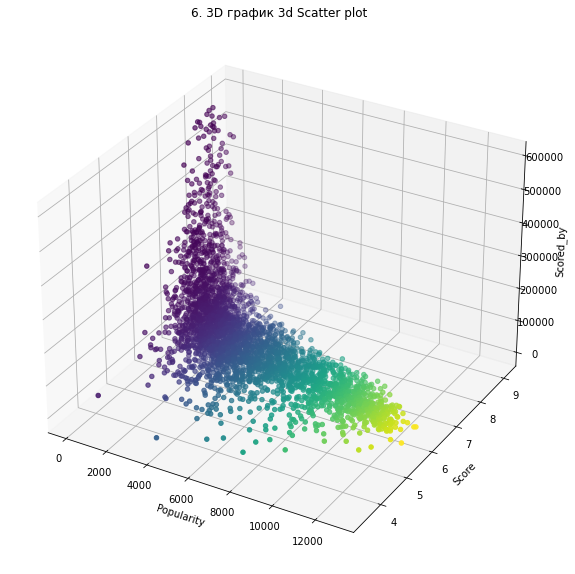

In [11]:
# 6. 3D GRAPHIC
ig = plt.figure()
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')

z = anime_df[anime_df.scored_by < 600000].set_index('type').loc['TV'].scored_by
x = anime_df[anime_df.scored_by < 600000].set_index(
    'type').loc['TV'].popularity
y = anime_df[anime_df.scored_by < 600000].set_index('type').loc['TV'].score
# Хитрая формула цвета зависит от координат точки
color = [xi + yi for xi, yi in zip(x, y)]
ax.scatter(x, y, z, c=color)
ax.set_title('6. 3D график 3d Scatter plot')
ax.set_zlabel("Scored_by")
ax.set_ylabel("Score")
ax.set_xlabel("Popularity")
plt.show()

In [12]:
#TASK3
from datetime import datetime
anime_df.to_csv('data/new_anime_data.csv')
#TASK4
#new colomn - duration of all episodes in this serial
anime_df.insert(5, 'final_duration', (anime_df.duration * anime_df.episodes))
anime_df.head(3)

,mal_id,aired_from,aired_to,duration,episodes,final_duration,genres,popularity,premiered,rank,age_rating,score,scored_by,source,studios,synopsis,title,title_english,type
0,1,1998-04-03,1999-04-24,24.0,26,624.0,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,"[{'mal_id': 14, 'name': 'Sunrise'}]","In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
1,100,2001-04-04,2001-06-27,23.0,13,299.0,"['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...",2075,Spring 2001,2703.0,PG-13 - Teens 13 or older,7.21,23787,Manga,"[{'mal_id': 34, 'name': 'Hal Film Maker'}]","Due to her father's remarriage, robust 16-year...",Shin Shirayuki-hime Densetsu Prétear,Prétear: The New Legend of Snow White,TV
2,1000,1978-03-14,1979-02-13,25.0,42,1050.0,"['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...",2980,Spring 1978,1008.0,PG-13 - Teens 13 or older,7.71,7059,Manga,"[{'mal_id': 18, 'name': 'Toei Animation'}]",It is 2977 AD and mankind has become stagnant....,Uchuu Kaizoku Captain Herlock,Space Pirate Captain Harlock,TV


# 2. Интерполяция кривой

Сгенерируйте от 5 до 20 точек со случайными разными координатами (x, y), расположите их на координатной плоскости

<font color="blue">Математичеки

Инерполяция : хотим построить не ломанную прямую (такие графики плохо читаются) а кривую. Для этого надо
восстановить промежуточные значения функции, которая задана точками в нашем случае
Для этого в общем случае надо найти некоторую функцию для расчёта промежуточных точек на соответствующих сегментах. 
Функции могут быть самыми разными, но чаще всего используют полиномы некоторой степени

По питоновски (т.е, чем полезна в анализе)

Интерполяция – это техника в Python, с которой вы можете оценить неизвестные точки данных между двумя известными точками данных.
Обычно используется для заполнения пропущенных значений в таблице или наборе данных с использованием уже известных значений. 
</font>

1. С помощью библиотеки scipy примените один из её [алгоритмов интерполяции](https://docs.scipy.org/doc/scipy/reference/interpolate.html) к сгенерированным данным

<font color="blue">Пользуюсь классом BarycentricInterpolator</font>

2. Изучите математический подход метод выбранного алгоритма интерполяции в scipy. Найдите и продемонстрируйте при сдаче реализацию метода в исходном коде библиотеки scipy. Найти можно в [github репозитории проекта](https://github.com/scipy/scipy)

<font color="blue">А именно
https://github.com/scipy/scipy/blob/744c75f35b06826c1d61be3e53031d532120cf0a/scipy/interpolate/_polyint.py#L508
</font>

3. Выберите среди методов интерполяции в scipy любой другой метод интерполяции (кроме линейной интерполяций). Реализуйте выбранный метод без использования сторонних библиотек. Разрешается использовать numpy для упрощения математичеких вычислений

<font color="blue">Возьмем метод interp1d вида nearest 

Если бы мы работали с изображением метод интерполяции ближайшего соседа добавил значение пикселя ближайшего соседа при увеличении изображения. С точками это работает так -Интерполяция методом ближайшего соседа (ступенчатая интерполяция) — метод интерполяции, при котором в качестве промежуточного значения выбирается ближайшее известное значение функции. 
https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Piecewise_constant.svg/1280px-Piecewise_constant.svg.png
То есть рисуем ступеньки и потом соединяем
</font>

4. Визуализируйте кривую интерполяции библиотечного и вашего алгоритмов с помощью  matplotlib. Сравните качество интерполяции своего и библиотечного методов, объясните разницу в качестве

<font color="blue">
</font>

[ 3.44258321 15.15465728 18.88906828 23.30879174 26.63309047 38.25497226
 40.57134276] [61.56613346 88.24893123 44.99766273 16.14539351 14.51137162 14.05148644
 21.37337   ]


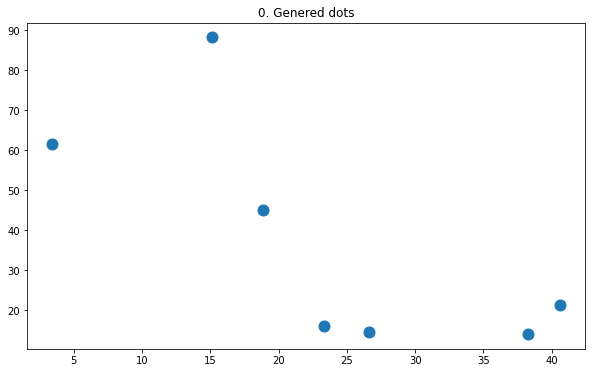

In [260]:
#Немного определений и подготвки данных
import numpy as np
plt.figure(figsize=(10, 6))
from scipy.interpolate import BarycentricInterpolator, interp1d, KroghInterpolator
#создаем точки
#x = np.linspace(0, 100,10)
x = np.random.random_sample(size = 7) * 50
x.sort()
y = np.random.random_sample(size = 7) * 100
print(x, y)
plt.title('0. Genered dots')
plt.plot(x, y, 'o', markersize=11)
plt.show()

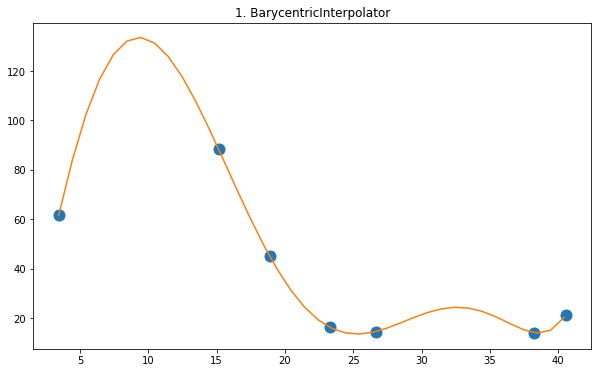

In [354]:
#TASK1
f1 = BarycentricInterpolator(x, y) 
plt.figure(figsize=(10, 6))
vec = np.arange(min(x), max(x))
plt.plot(x, y, 'o', markersize=11)
plt.title('1. BarycentricInterpolator')
plt.plot(vec, f1(vec))
plt.show()

In [ ]:
#TASK2
#https://github.com/scipy/scipy/blob/744c75f35b06826c1d61be3e53031d532120cf0a/scipy/interpolate/_polyint.py#L508


In [262]:
#TASK3
f3 = interp1d(x, y, 'nearest')
def custom_nearest_interpolator(x, y, x_new):
    y = np.array(y)
    x_new = np.array(x_new)
    x_bds = np.array(x) / 2.0 #расстояния между точками, будущие границы
    x_bds = x_bds[1:] + x_bds[:-1]
    x_new_indx = np.searchsorted(x_bds, x_new, 'left')  #возвращает индексы в которые должны быть вставлены указанные элементы,
    # что бы порядок сортировки был сохранен. Как бы длины ступенек
    return y[x_new_indx] 


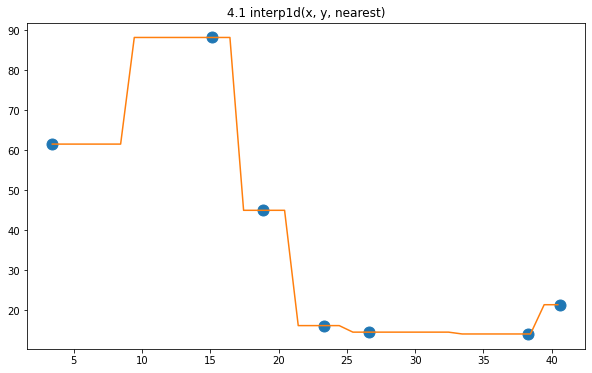

In [264]:
#TASK4 P1
plt.figure(figsize=(10, 6))
plt.title('4.1 interp1d(x, y, nearest)')
plt.plot(x, y, 'o', markersize=11)
plt.plot(vec, f3(vec))
plt.show()

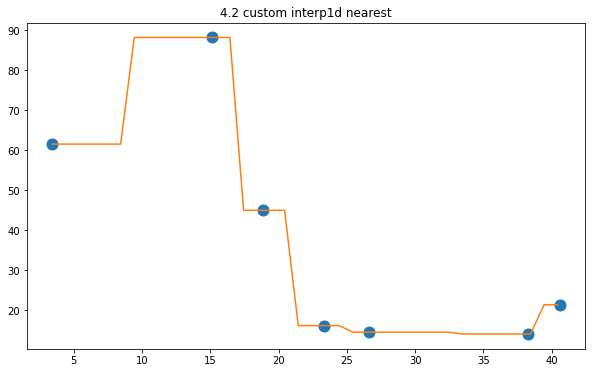

In [265]:
#TASK4 P2
plt.figure(figsize=(10, 6))
plt.title('4.2 custom interp1d nearest')
plt.plot(x, y, 'o', markersize=11)
plt.plot(vec, custom_nearest_interpolator(x, y, vec))
plt.show()

# 3. Быстрая гистограмма

Иногда хочется получить дискретное распределение из N колонок. Но пока что для этого у нас есть только plt.hist(), которая тратит много времени на отрисовку графика. Вам предлагается реализовать свою функцию построения дискретного распределения

1. Алгоритм должен получать на вход список чисел и количество колонок гистограммы. Возвращать нужно значения столбцов (ось абсцисс гистограммы) и количество значений, принадлежащее столбцу (ось ординат гистограммы). Пример с использованием plt показан ниже, сигнатура функции также показана ниже
1. Изучите функцию [plt.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html). Это такая же гистограмма как plt.hist, но в отличие от hist требуется явно указывать высоту колонок и их название
1. С помощью результатов своего алгоритма и plt.bar постройте гистограмму по массиву из 50+ случайных чисел. Графики plt.bar по вашему алгоритму и plt.hist() должны совпадать, что подтвердит корректность работы вашего алгоритма
1. Сравните скорость построения распределения по массиву чисел с помощью своего алгоритма и с помощью plt.hist. В jupyter рекомендуется использовать built-in magic commands, а именно timeit. Но можно обойтись и ручными измерениями времени выполнения

Значения колонок: [3. 2. 2. 2.]
Названия колонок: [1.   1.75 2.5  3.25 4.  ]


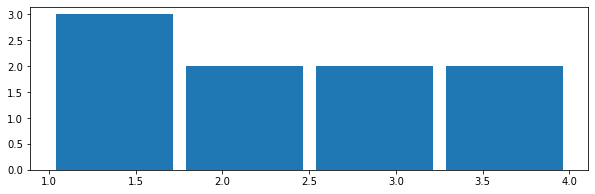

In [357]:
# Пример гистограммы с помощью plt.hist()
import matplotlib.pyplot as plt

array = [1,1,2,3,4,1,2,3,4]

value_counts, bins_names, visual_figure = plt.hist(array, 
                                                    bins=len(set(array)), 
                                                    rwidth=0.9)
# Параметр rwidth и визуализацию в своей функции реализовывать не требуется
print('Значения колонок:', value_counts)
print('Названия колонок:', bins_names)

In [395]:
#TASK1
from typing import List, Tuple, Union


def fast_hist(array: List[Union[int, float]],
                bins: int) -> Tuple[List[int], List[float]]:
        """
        Builds bins' labels and bins' value counts for given array
        :param array: array with numeric values
        :param bins:  number of bins in result distribution
        :return: Two lists: 
                first contains value counts of each bin,
                second contains list of bins' labels
        """
        y_array = []
        x_array = [float(i) * #номер столбца
                        (max(array) - min(array)) / float(bins) #ширина столбца
                        + min(array) #начало корординат
                        for i in range(bins + 1)]
        for i in range(0, len(x_array) - 1):
                y_array.append(
                                len([j for j in array #набираем длинну количеством
                                        if j >= x_array[i] and j <= x_array[i + 1]])) 
        return (y_array, x_array[:-1], 0.9 * (max(array) - min(array)) / float(bins))


Значения колонок: [3, 2, 2, 2]
Названия колонок: [1.0, 1.75, 2.5, 3.25]


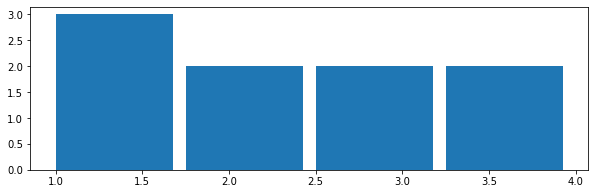

In [359]:
#TASK2
#Опробуем на примере из примера
values, bins, width = fast_hist(array, 4)
plt.bar(bins, values, width=width, align='edge')
print('Значения колонок:', values)
print('Названия колонок:', bins)

Значения колонок: [11, 6, 8, 8, 17]
Названия колонок: [0.0, 9.6, 19.2, 28.8, 38.4]


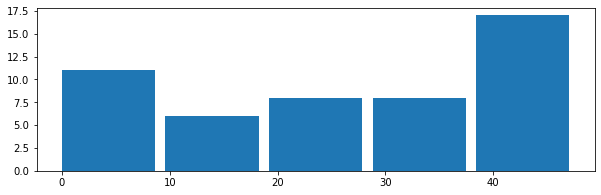

In [360]:
#TASK3 P1
#Кастомный вариант
new_array = np.random.randint(0, 50, 50)
plt.figure(figsize=(10, 3))
values, bins, width = fast_hist(new_array, 5)
plt.bar(bins, values, width = width, align = 'edge')
print('Значения колонок:', values)
print('Названия колонок:', bins)


Значения колонок: [11, 6, 8, 8, 17]
Названия колонок: [0.0, 9.6, 19.2, 28.8, 38.4]


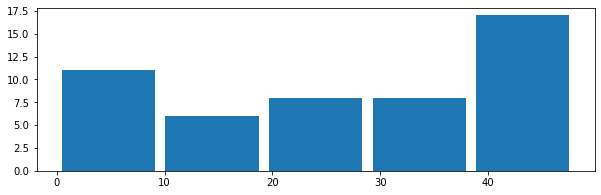

In [361]:
#Встроенным инструментом
plt.hist(new_array, 5, rwidth=0.9)
print('Значения колонок:', values)
print('Названия колонок:', bins)


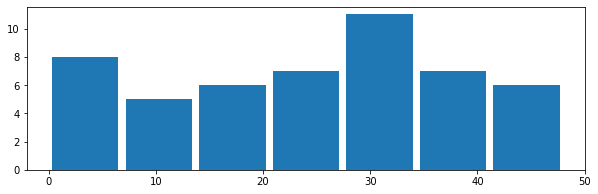

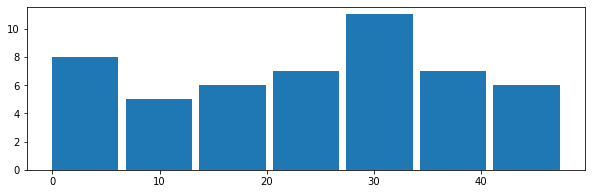

Встроенная реализация, время: 0.21941161155700684
Кастомная реализация, время: 0.18849635124206543


In [397]:
#TASK4 
import time
def time_checker() :
    ar = np.random.randint(0, 50, 50)
    t1 = time.time()
    plt.hist(ar, 7, rwidth=0.9)
    plt.show()
    t2 = time.time()
    values, bins, width = fast_hist(ar, 7)
    plt.bar(bins, values, width=width, align='edge')
    plt.show()
    t3 = time.time()
    print('Встроенная реализация, время: ' + str(t2 - t1))
    print('Кастомная реализация, время: ' + str(t3 - t2))
time_checker()

In [ ]:
#После порядка 30 испытаний выявлено что время работы встраоенной реализации чуточку быстрее в общем случае